In [1]:
import pandas as pd
import numpy as np
import sqlite3

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, \
                            mean_absolute_error, \
                            r2_score
from sklearn.metrics import make_scorer
from sklearn.linear_model import \
    ElasticNet, \
    Lasso

import time

In [2]:
clean = '../../datas/CLEAN/E2/'

con = sqlite3.connect(clean + 'E2.db')
X = pd.read_sql('select * from X_amelioration', con, index_col='index')
y = pd.read_sql('select * from y_amelioration', con, index_col='index')

con.close()

X.shape, y.shape

((99411, 20), (99411, 1))

In [3]:
model = ElasticNet(random_state=0)
# model = Lasso(random_state=0)

scorers = {
    'MSE': make_scorer(mean_squared_error, greater_is_better=False),
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
    'R2':  make_scorer(r2_score, greater_is_better=True)
}
params = {
    'alpha': [1e-5, 1e-2, 1e-1, 1],
    'l1_ratio': np.arange(0.1, 0.9, 0.25)
}
grid = GridSearchCV(
    estimator=model, 
    param_grid=params, 
    cv=3,
    scoring=scorers,
    refit='MSE',
    n_jobs=-1
)

In [4]:
start_time = time.time()

result = grid.fit(X, y)

print("--- %.3s seconds ---" % (time.time() - start_time))

--- 5.2 seconds ---


In [5]:
print(grid.best_params_, grid.best_score_, '\n')
stop_int = 10
for param, squared, absolute, r2, stop in zip(
        grid.cv_results_['params'], 
        grid.cv_results_['mean_test_MSE'], 
        grid.cv_results_['mean_test_MAE'], 
        grid.cv_results_['mean_test_R2'], 
        range(stop_int)
    ):
    if stop == stop_int: break
    print(param, '\t%.2f\t%.2f\t%.3f' %(squared, absolute, r2))

{'alpha': 0.01, 'l1_ratio': 0.8499999999999999} -33.9648383054105 

{'alpha': 1e-05, 'l1_ratio': 0.1} 	-34.53	-4.28	0.297
{'alpha': 1e-05, 'l1_ratio': 0.35} 	-34.54	-4.28	0.297
{'alpha': 1e-05, 'l1_ratio': 0.6} 	-34.54	-4.28	0.297
{'alpha': 1e-05, 'l1_ratio': 0.8499999999999999} 	-34.54	-4.28	0.297
{'alpha': 0.01, 'l1_ratio': 0.1} 	-33.99	-4.27	0.308
{'alpha': 0.01, 'l1_ratio': 0.35} 	-33.98	-4.27	0.308
{'alpha': 0.01, 'l1_ratio': 0.6} 	-33.97	-4.27	0.309
{'alpha': 0.01, 'l1_ratio': 0.8499999999999999} 	-33.96	-4.27	0.309
{'alpha': 0.1, 'l1_ratio': 0.1} 	-34.79	-4.34	0.292
{'alpha': 0.1, 'l1_ratio': 0.35} 	-34.81	-4.34	0.291


# Sauvegarde du modèle

In [6]:
from joblib import dump, load
from pathlib import Path

# dossier_pickle = 'pickle/'
# Path(dossier_pickle).mkdir(parents=True, exist_ok=True)
# dump(grid.best_estimator_, dossier_pickle + 'model_amelioration' + '.pkl')

# Comparaison de la predicition avec la cible

In [50]:
temp_X = X.copy()
temp_X['cible'] = y.copy()
temp_X = temp_X.sample(1000)
temp_X.reset_index(inplace=True, drop=True)

temp_y = temp_X.pop('cible')

pred_y = pd.Series(grid.best_estimator_.predict(temp_X))

[Text(0.5, 0, 'Temps de livraison'), Text(0, 0.5, 'Predicition')]

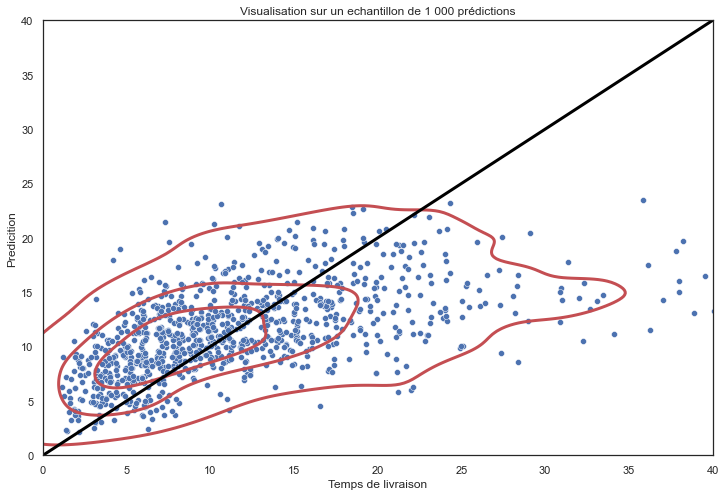

In [56]:
import seaborn as sns
import matplotlib.lines as lines
sns.set(rc={'figure.figsize':(12,8)})
sns.set_theme(style="white")

ax = sns.scatterplot(x=temp_y, y=pred_y)
sns.kdeplot(x=temp_y, y=pred_y, levels=4, color="r", linewidths=3)
ax.set_title('Visualisation sur un échantillon de 1 000 prédictions')
ax.add_artist(lines.Line2D([0, 40], [0, 40], 3, color='black'))
ax.set_ylim((0,40))
ax.set_xlim((0,40))
ax.set(xlabel='Temps de livraison', ylabel='Predicition')

In [ ]:
pred_y

0      9.927080
1     13.887214
2      8.625751
3     15.426879
4      8.153082
        ...    
95     3.846956
96    10.141902
97    11.835174
98    13.640716
99    10.314775
Length: 100, dtype: float64